# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Регуляризация

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

sns.set_theme(font_scale=1)

### 0. Описание проблемы

**Линейная регрессия** - это  простая и хорошо интерпретируемая модель для работы с данными. Однако, как и всегда, нет ничего абсолютно универсального, и у всего есть свои недостатки. 

Довольно очевидной проблемой является то, что функциональная зависимость между фичами и таргетом может оказаться нелинейной. Тем не менее, даже, когда датасет, кажется, должен хорошо аппроксимироваться прямой, качество предсказаний может быть очень низким. Одним из возможных препятствий может оказаться мультиколлинеарность.

**Мультиколлинеарность** - это наличие линейной или около линейной зависимости между признаками. Иначе говоря, между переменными может наблюдаться высокая корреляция, что в итоге приводит к неправильным (часто очень завышенным) коэффициентам модели. 

*К примеру, пусть есть переменная $y$, которую мы хотим научиться предсказывать при помощи переменных $x_1$, $x_2$ и $x_3$. Причем истинная зависимость выглядит просто как $y = x_1$. Однако нам могло не повезти, и величины могли оказаться линейно-зависимыми как-нибудь так: $x_1~+~x_2~-~2\cdot~x_3 = 0$. В этом случае линейная модель не сможет различить между собой такие варианты коэффициентов как (1, 0, 0), (0, -1, 2), (101, 100, -200)... и, скорее всего, программа просто упадет, так как будет происходить обращение вырожденной матрицы (аналогично делению на ноль). В реальных данных чаще всего взаимосвязь между переменными является приблизительной (например, $x_2 \approx 2 \cdot x_3$), что формально не помешает применению линейной регрессии, но приведёт к неправдоподобно большим коэффициентам и плохой точности.*

Продемонстрируем данное явление на примере [датасета](https://www.nature.com/articles/s41598-020-76117-y) из последнего домашнего задания по экспрессиям различных генов (RNA-seq), используемых для предсказания возраста пациентов. 

*Данные были получены при помощи РНК секвенирования, которое для каждого образца считает число молекул РНК (различные изоформы могут как учитываться, так и нет), экспрессированных с генов. Таким образом получается таблица, в которой представлены различные образцы по одной оси и названия генов по другой. На пересечении стоит число детектированных молекул, которое иногда называют каунтом.*

### 1. Метод наименьших квадратов

In [4]:
df = pd.read_csv('C:/Users/cara_/Documents/Rnaseq_age_reg.csv')
df.head()

,Age,NM-005483,NM-001286734,NM-080668,NM-001142557,NM-001258451,NM-007317,NM-005030,NM-002105,NM-001067,...,NM-001012507,NM-016448,NM-017669,NM-001160046,NM-004219,NM-001083961,NR-125339,NM-014501,NM-001278324,NM-005496
0,19,0.132011,-0.134300,0.451310,-0.022878,0.018667,0.093849,-0.052866,0.016490,0.124796,...,0.399409,0.603130,0.353623,-0.026512,0.214482,0.089629,-0.373683,-0.634992,0.150399,0.139014
1,19,0.547094,0.048433,0.616353,0.100657,0.449449,0.031947,-0.095406,0.002124,0.297503,...,-0.695090,1.047713,0.274719,-0.026406,-0.174677,0.188904,0.107204,-0.512265,-0.276802,-0.436953
2,19,-0.128915,0.058490,0.545019,0.011446,0.167808,0.193595,0.330663,0.269069,0.271928,...,-0.235994,0.249005,0.185740,-0.073686,0.207569,0.219520,0.104442,0.047305,-0.326697,-0.385664
3,19,0.108909,-0.304070,0.137853,-0.144723,0.454118,0.382229,0.331013,0.438284,0.265608,...,-0.249369,0.099310,0.012135,-0.379289,0.173875,0.458437,-0.295837,0.549386,0.482001,-0.341235
4,20,1.035609,0.878312,0.721720,0.760656,0.779344,0.948431,1.111776,0.548357,0.689128,...,0.781208,1.271952,0.471733,0.685357,1.142871,0.926903,0.571224,0.714480,0.811737,0.854124


Выделим независимые и зависимую переменные и разобьем датасет на train и test.

In [5]:
X, y = df.drop('Age', axis=1), df['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((114, 164), (29, 164), (114,), (29,))

Сначала попробуем аппроксимировать данные линейной регрессией. Обучим модель, посчитаем коэффициент детерминации [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html), и MAPE на тесте:

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X = X_test)

print(f'R2: {round(r2_score(y_test, y_pred), 2)} \nMAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 2)}')

R2: -0.22 
MAPE: 2.03


**Вывод**: $R^2$ отрицательный, а MAPE составляет 200%. Модель никуда не годится.

### 2. Проверка мультиколлинеарности

Проверим, не связаны ли между собой значения признаков. Самым простым вариантом является построение матрицы [коэффициентов корреляций](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), показывающей наличие монотонных зависимостей между признаками. В библиотеке `seaborn` для её визуализации есть функция [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

$$r_{pearson}(X, Y) = \frac{\sum_{i=1}^n(X_i - \overline{X})(Y_i - \overline{Y})}{\sqrt{\sum_{i=1}^n(Y_i - \overline{Y})^2}\sqrt{\sum_{i=1}^n(Y_i - \overline{Y})^2}} = \frac{cov(X, Y)}{S_X \cdot S_Y},$$
где $X$ и $Y$ - векторы значений двух признаков длины $n$, $S$ - выборочные среднеквадратичные отклонения,  $cov$ - выборочная ковариация, $\overline{X}$ и $\overline{Y}$ - выборочные средние $X$ и $Y$. 

Чем ближе $r_{pearson}$ к $\pm1$, тем выше степень линейной зависимости между признаками. На графике это выглядит так:

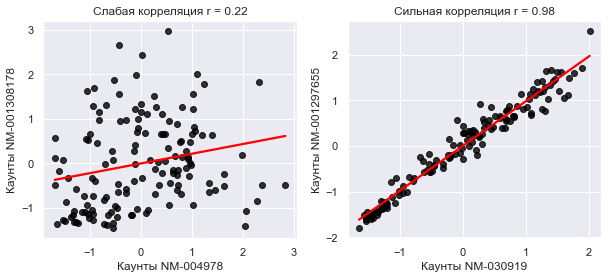

In [7]:
plt.figure(figsize=(10, 4))

# Отобразим зависимость между значениями двух слабокоррелирующих признаков
plt.subplot(1, 2, 1)
sns.regplot(x=X["NM-004978"], y=X["NM-001308178"],
            scatter_kws={"color": "black"}, line_kws={"color": "red"}, ci=None)

plt.xlabel("Каунты NM-004978")
plt.ylabel("Каунты NM-001308178")

weak_corr = np.corrcoef(X["NM-004978"], X["NM-001308178"])[0, 1]
plt.title(f"Слабая корреляция r = {weak_corr:.2f}")

# Отобразим зависимость между значениями двух сильнокоррелирующих признаков
plt.subplot(1, 2, 2)
sns.regplot(x=X["NM-030919"], y=X["NM-001297655"],
            scatter_kws={"color": "black"}, line_kws={"color": "red"}, ci=None)

plt.xlabel("Каунты NM-030919")
plt.ylabel("Каунты NM-001297655")

strong_corr = np.corrcoef(X["NM-030919"], X["NM-001297655"])[0, 1]
plt.title(f"Сильная корреляция r = {strong_corr:.2f}");

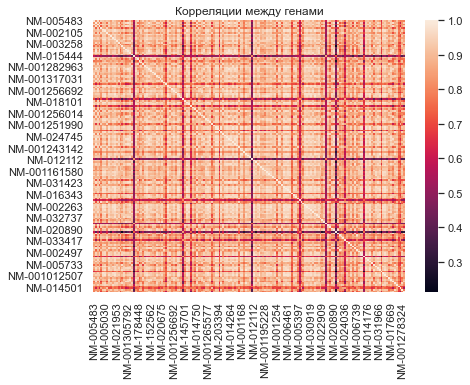

In [8]:
# Считаем корреляции между генами и визуализируем что получилось
plt.figure(figsize=(7, 5))
sns.heatmap(X_train.corr()).set(title="Корреляции между генами");

Видно, что значения корреляций на обоих графиках очень высокие (где-то больше 0,8). Чтобы еще четче это увидеть, воспользуемся функцией [sns.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html), которая кластеризует/сортирует данные для лучшей визуализации.

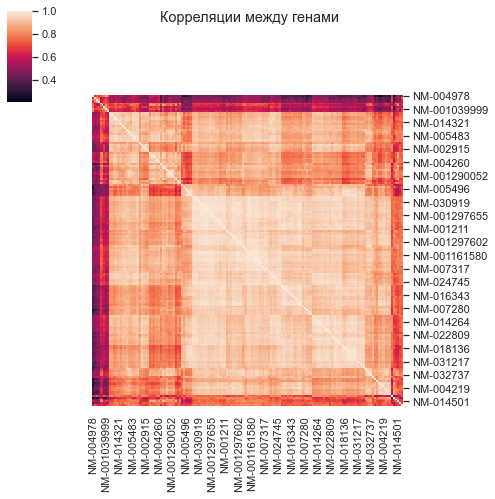

In [9]:
pearson_clusters = sns.clustermap(X_train.corr(), figsize=(7, 7))

pearson_clusters.ax_row_dendrogram.set_visible(False) # Уберем дендрограммы
pearson_clusters.ax_col_dendrogram.set_visible(False)
pearson_clusters.figure.suptitle("Корреляции между генами");

Светлый цвет соответствует сильной корреляции. Видно, что среди признаков много линейно-зависимых. Это довольно типично для bulk RNA-seq, поскольку число генов обычно много больше числа образцов. Посмотрим, как выглядят зависимости между значениями сильно- и слабокоррелирующих признаков.

<style>
   .semi {
    opacity: 0.6; /* Полупрозрачность элемента */
   }
</style>

<div class="semi">
   <h4>
2* VIF
   </h4>
</div>

<style>
   .semi {
    opacity: 0.6; /* Полупрозрачность элемента */
    font-size: 11.5pt; 
   }
</style>

<div class="semi">

  Другим способом продемонстрировать мультиколлинеарность является коэффициент VIF (Variance Inflation Factor). Мы будем строить линейную модель, используя в качестве целевой переменной один из признаков (генов), а остальные в качестве независимых переменных. То есть мы проверяем, существует ли между признаками линейная зависимость. Метрика определяется следующим образом: $$VIF_i = \frac{1}{1 - R_i^2},$$ где $R_i^2$ - это значение $R^2$ для линейной регрессии i-го гена по остальным. Считается, что 
  - VIF = 1 &mdash; переменные не коррелируют;
  - 1 < VIF < 10 &mdash; переменные коррелируют частично;
  - VIF > 10 &mdash; переменные коррелируют очень сильно.
</div>

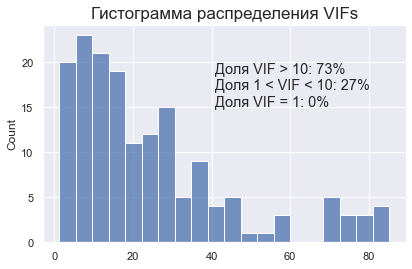

In [10]:
genes = X_train.columns.to_list() # Создаем список всех генов из нашей таблички
VIFs = np.array([]) # Список, в котором мы будем хранить значения VIF для каждого гена

for gene in genes:
    X_VIF, y_VIF = X_train.drop(gene, axis=1), X_train[gene] 

    # Не пользуемся данными теста (X_test, y_test), так как мы исследуем свойства нашего датасета, а не подгоняемся под него
    X_train_VIF, X_test_VIF, y_train_VIF, y_test_VIF = train_test_split(X_VIF, y_VIF, test_size=0.2, train_size=0.8, random_state=42)

    model_VIF = LinearRegression()
    model_VIF.fit(X_train_VIF, y_train_VIF)

    r2 = r2_score(y_test_VIF, model_VIF.predict(X_test_VIF))

    VIFs = np.append(VIFs, 1 / (1 - r2)) 

# Посчитаем долю (в %) генов по пороговым значениями
VIFs_high_ratio = round((VIFs > 10).sum() / VIFs.shape[0], 2) * 100
VIFs_moderate_ratio = round(((VIFs > 1) & (VIFs < 10)).sum() / VIFs.shape[0], 2) * 100
VIFs_no_ratio = round((VIFs == 1).sum() / VIFs.shape[0], 2) * 100

# Визуализируем наши результаты
plt.figure(figsize=(6.5, 4))

hist = sns.histplot(VIFs, bins=20)
hist.axes.set_title("Гистограмма распределения VIFs", fontsize=17)
plt.annotate(f"Доля VIF > 10: {VIFs_high_ratio:.0f}% \nДоля 1 < VIF < 10: {VIFs_moderate_ratio:.0f}% \nДоля VIF = 1: {VIFs_no_ratio:.0f}%", xy=(0.475, 0.63), xycoords='axes fraction',
             fontsize=14.5);

<style>
   .semi {
    opacity: 0.6; /* Полупрозрачность элемента */
    font-size: 11.5pt;
   }
</style>

<div class="semi">

В нашем случае мы получаем очень большие VIF, что означает наличие значительной линейной зависимости между признаками в датасете.

</div>

### 3. Регуляризация

Чтобы бороться с проблемой мультиколлинеарности, можно использовать модификации линейной модели, которые добавляют штраф за слишком большие значения коэффициентов регрессии в функцию потерь. Этот процесс называется регуляризацией. Самыми распространенными являются $l_1$ и $l_2$ регуляризации. В задаче регрессии ими обладают модели 
 [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) и [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). 

* **Ridge** &mdash; это модель линейной регрессии, которая минимизирует функционал $\lVert y - X \theta\rVert^2_2 + \alpha \cdot \lVert\theta\rVert^2_2$, где $y$ &mdash; истинные значения целевой переменной, $X$ &mdash; матрица "объект-признак", $\theta$ &mdash; параметры модели, $\alpha$ &mdash; параметр регуляризации.  
* **Lasso**-регрессия минимизирует $\lVert y - X \theta\rVert^2_2 + \alpha \cdot \lVert\theta\rVert_1$   
* **Elastic**-регрессия минимизирует $\lVert y - X\theta\rVert^2_2 + \alpha_1 \cdot \lVert\theta\rVert_1 + \alpha_2 \cdot \lVert\theta\rVert^2_2$. Таким образом Elastic-регрессия является компромиссом между $l_1$ и $l_2$ регуляризациями (т. е. между Lasso- и Ridge-регрессиями). 

####  Стандартизация (=нормализация)
Перед тем как пользоваться этими моделями наши данные нужно сначала преобразовать. Регуляризация использует в своей реализации значения коэффициентов модели, а значит, они должны быть сопоставимы между собой, иметь одинаковый масштаб. Для этого воспользуемся классом [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), который из каждого значения признака (то есть по столбцам в нашем случае) вычитает его среднее значение по всем образцам и потом делит на среднеквадратичное отклонение. Это позволяет убедиться, что все признаки имеют среднее и дисперсию равные 0 и 1, соответственно.

Также на практике часто пользуются другой нормализацией &mdash; [MinMaxscaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), которая позволяет перевести все значения переменной в фиксированный диапазон, к примеру, [0, 1] или [-1, 1]. Однако сейчас нам она не нужна.

$$StandardScaler: x_{ij}' = \frac{x_{ij} - \mu_j}{S_j};$$

$$MinMaxScaler: x_{ij}' = \frac{x_{ij} - m_j}{M_j - m_j},$$
где $x_{ij}$ и $x_{ij}'$ - значения признака $j$ для объекта $i$ до и после стандартизации, $\mu_j$ - выборочное среднее значение признака $j$, $S^2_j$ -  его выборочная дисперсия, $m_j$ и $M_j$ - минимальное и максимальное значения признака j по всем объектам.

In [11]:
scaler = StandardScaler()

# Нормируем train и test. Не забываем, что нельзя применять
# метод fit для тестовой выборки, чтобы модель ничего не знала о тестовых данных.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)   # писать .fit_transform(X_test) КАТЕГОРИЧЕСКИ запрещается

Теперь рассмотрим все варианты регуляризаций и поймем, как значения гиперпараметров влияют на качество результатов.

#### Практика
#### 3.1 Ridge-регрессия

Создадим модель Ridge-регрессии:

In [12]:
model_ridge = Ridge(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация (default = 1.0)
    alpha=1.0,

    # использовать ли параметр-остаток при обучении (default = True)
    fit_intercept=True,
)

Обучите эту модель:

In [17]:
model_ridge.fit(X_train, y_train)


Ridge()

Выведите перые двадцать коэффициентов модели:

In [21]:
print(model_ridge.coef_[:20])

[ 0.78645761  1.30597044  6.96048722 -3.07844368 -1.99856178  1.27732251
  3.86768865  2.18830576 -6.90246306 -5.23283179 -2.36982717 12.992607
  5.76717875  1.90672727 -1.9983426   2.95168298  6.16614571  6.12126098
  1.34045585  0.63549361]


Выведите значение свободного параметра:

In [29]:
model_ridge.intercept_

45.271929824561404

Выведите настройки модели, использованные при обучении, при помощи метода `get_params`:

In [22]:
params = model_ridge.get_params()
params

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

Сделайте предсказания модели по `X_test` и посчитайте метрики $R^2$ и MAPE.

In [23]:
y_pred = model_ridge.predict(X_test)
print(r2_score(y_test, y_pred), 'R^2')
print(mean_absolute_percentage_error(y_test, y_pred), 'MAPE')

0.7076487268772886 R^2
0.8535362804543591 MAPE


Теперь создадим функцию для визуализации наших результатов, чтобы проследить, как меняются предсказания в зависимости от параметров моделей.

In [24]:
# на этапе выполнения семинара в данный код можно не смотреть

def linear_predictor(alpha, model, count_of_objects=20):
    """Данная функция строит график предсказаний модели 
    на первых count_of_objects объектах датасета.
    
    :param alpha: коэффициент регуляризации
    :param model: тип модели
    """
    # Выберем тип модели
    if model == 'Ridge':
        model = Ridge(alpha=alpha, fit_intercept=True, max_iter=100, tol=0.0001)
    elif model == 'Lasso':
        # см. ниже по ноутбуку
        model = Lasso(alpha=alpha, fit_intercept=True, max_iter=100, tol=0.0001)
    elif model == 'Elastic':
        # см. ниже по ноутбуку
        model = ElasticNet(alpha=alpha, fit_intercept=True, max_iter=100, tol=0.0001)

    # Обучим модель и посчитаем ее предсказания
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Отобразим истинные значения таргета и предсказанные нашей моделью
    plt.figure(figsize=(14, 5))

    plt.scatter(np.arange(count_of_objects), y_pred[:count_of_objects], 
              color='#0066FF', label='Предсказания модели')
    plt.plot(np.arange(count_of_objects), y_pred[:count_of_objects], 
          color='#0066FF')
    plt.scatter(np.arange(count_of_objects), y_test[:count_of_objects], 
                color='#FF3300', label='Истинные значения')

    plt.grid(ls=':')
    plt.xlabel('Номер объекта', fontsize=19)
    plt.xticks(np.arange(count_of_objects))
    plt.ylabel('Предсказание', fontsize=19)
    plt.title('Предсказания на {} объектах'.format(count_of_objects), 
              fontsize=22)
    plt.legend(fontsize=19)
    plt.show()

In [26]:
import ipywidgets as widgets

# Создадим виджет, но не будем отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=2, step=0.01, value=1),
    model='Ridge'
);

# Выведем слайдер для изменения параметров модели
display(widgets.HBox(ip.children[:1]))

# Отобразим вывод функции
display(ip.children[-1])
ip.update() # Запуск функции до первого изменения слайдеров

Output()

Сделайте выводы о роли параметра в Ridge-регрессии.

**Выводы:** альфа отвечает за силу регуляризации, увеличение значения alpha увеличивает силу регуляризации, что приводит к меньшим коэффициентам модели и, следовательно, к большему штрафу за сложность модели.

#### 3.2 Lasso-регрессия

Создадим модель Lasso-регрессии:

In [27]:
model_lasso = Lasso(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация (default = 1.0)
    alpha=1.0,

    # использовать ли параметр-остаток при обучении (default = True)
    fit_intercept=True,

    # максимальное количество итераций в методе оптимизации (default = 1000)
    max_iter=1000,

    # точность решения (не забываем, что Lasso использует итеративные методы решения)
    # чем значение меньше, тем больше может потребоваться итераций (default = 1e-4)
    tol=0.0001,

    # использовать ли предпосчитанную матрицу Грамма для ускорения расчетов (default = False)
    precompute=True 
)

Обучите эту модель:

In [28]:
model_lasso.fit(X_train, y_train)

Lasso(precompute=True)

Выведите первые двадцать коэффициентов модели:

In [31]:
print(model_lasso.coef_[:20])

[ 0.          0.          0.          0.          0.         -0.
 -0.          0.         -0.         -0.          0.         -0.
  0.          0.         -7.85609647 -0.         -0.          0.
  0.          0.        ]


Выведите значение свободного параметра (intercept):

In [30]:
model_lasso.intercept_

45.271929824561404

Вместо обычного списка коэффициентов Lasso хранит в себе их [разреженное представление](https://python-school.ru/blog/python/sparse-matrix/), то есть только ненулевые элементы. Почему?

**Ответ:** таким образом мы избавляемся от ненужных признаков (часто мультиколлинеарных), чтобы получать адекватные оценки и матрицы и избегать огромных дисперсий

Напечатайте значение этого объекта, которое хранится в `sparse_coef_`:

In [39]:
print(model_lasso.sparse_coef_)

  (0, 14)	-7.856096469537812
  (0, 38)	-7.8347805541654685
  (0, 43)	2.825448763079286
  (0, 51)	-11.623052020720568
  (0, 66)	1.668124613087754
  (0, 104)	-2.1340082049524485
  (0, 108)	4.236573072156086
  (0, 120)	5.684247447779691
  (0, 122)	5.053883231173494
  (0, 132)	4.724729633970652
  (0, 136)	-4.372801621294411
  (0, 155)	0.48775555093417194
  (0, 158)	-12.778303626557435
  (0, 159)	2.543678067168875
  (0, 161)	7.878557092019181
  (0, 163)	2.398955259190015


Сделайте предсказания модели по `X_test` и посчитайте метрики $R^2$ и MAPE.

In [37]:
y_pred_lasso = model_ridge.predict(X_test)
print(r2_score(y_test, y_pred_lasso), 'R^2')
print(mean_absolute_percentage_error(y_test, y_pred_lasso), 'MAPE')

0.7076487268772886 R^2
0.8535362804543591 MAPE


Визуализируем данные аналогично примеру с Ridge-регрессией

In [40]:
# Создадим виджет, но не будем отображать его
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=0.0001, max=15, step=0.1, value=1),
    model='Lasso'
);

# Выведем слайдер для изменения параметров модели
display(widgets.HBox(ip.children[:1]))

# Отобразим вывод функции
display(ip.children[-1])
ip.update() # Запуск функции до первого изменения слайдеров

Output()

Сделайте выводы о роли параметра в Lasso-регрессии.

**Выводы:** ведет к уменьшению распределения коэффициентов, а следовательно, к увеличению количества коэффициентов, которые становятся нулевыми, что сначала хорошо сказывается на результатах но можно "переборщить".

#### 3.3 Elastic-регрессия

Теперь разберемся аналогично с ElasticNet.

In [32]:
model_elastic = ElasticNet(
    # коэффициент регуляризации, чем больше - тем сильнее регуляризация (default = 1.0)
    alpha=0.01, 

    # какой регуляризации отдавать предпочтение: l1, а не l2 (default = 0.5)
    l1_ratio=0.6, 

    # использовать ли параметр-остаток при обучении (default = True)
    fit_intercept=True, 

    # максимальное количество итераций в методе оптимизации (default = 1000)
    max_iter=5000,

    # точность решения, 
    # чем значение меньше, тем больше может потребоваться итераций (default = 1e-4)
    tol=0.0001, 

    # использовать ли предпосчитанную матрицу Грамма для ускорения расчетов (default = False)
    precompute=True
)

Вот так выглядит связь между `alpha`, `l1_ratio` и $\alpha_1, \alpha_2$, которые мы вводили:

$$
\verb|alpha| = \alpha_1 + 2\alpha_2 \cdot
\\
\verb|l1_ratio| = \frac{\alpha_1}{\alpha_1 + 2\alpha_2}
\\
\alpha_1 = \verb|alpha| \cdot \verb|l1_ratio|\cdot
\\
\alpha_2 = \frac{1}{2} \verb|alpha| \cdot (1 - \verb|l1_ratio|)
$$

Обучите модель.

In [33]:
model_elastic.fit(X_train, y_train)

ElasticNet(alpha=0.01, l1_ratio=0.6, max_iter=5000, precompute=True)

Выведите первые двадцать коэффициентов модели и значение свободного параметра (intercept).

In [34]:
print(model_elastic.coef_[:20])

[  0.           2.36725558   7.64630128  -2.73750029  -3.56906058
   0.33395054   4.22567732   2.77045758 -11.47295796  -6.41767817
  -2.56053983  19.94974819   5.52326416   1.30653461   0.
   3.75281586   9.52786042   5.94723451   0.16515342   0.        ]


In [35]:
model_elastic.intercept_

45.271929824561404

Напечатайте, как выглядит разреженное представление коэффициентов. Есть ли разница по сравнению с Lasso? Почему?

In [41]:
print(model_elastic.sparse_coef_)

  (0, 1)	2.36725557983164
  (0, 2)	7.646301278064007
  (0, 3)	-2.737500290704258
  (0, 4)	-3.56906058490381
  (0, 5)	0.333950536655673
  (0, 6)	4.225677319937135
  (0, 7)	2.77045757647706
  (0, 8)	-11.472957958785313
  (0, 9)	-6.417678167729657
  (0, 10)	-2.5605398281752447
  (0, 11)	19.949748193908068
  (0, 12)	5.523264160045847
  (0, 13)	1.3065346113884175
  (0, 15)	3.7528158646941
  (0, 16)	9.527860424822759
  (0, 17)	5.947234510210291
  (0, 18)	0.16515342080147793
  (0, 20)	-2.0158413834103186
  (0, 21)	3.0579952762585605
  (0, 22)	3.0711803776000566
  (0, 23)	-2.3706889765226635
  (0, 24)	10.64055059329445
  (0, 25)	-3.4784274337784935
  (0, 27)	2.252664054951224
  (0, 28)	-18.029347165003188
  :	:
  (0, 138)	8.627150602123935
  (0, 139)	-1.2884854078167145
  (0, 140)	-3.6720371751509244
  (0, 141)	-7.41448076141185
  (0, 142)	-5.569349822652346
  (0, 144)	-3.967027126120129
  (0, 145)	-13.621944631877486
  (0, 146)	-11.302718973673011
  (0, 147)	-3.3141764211600178
  (0, 148)	16.

**Ответ:** elastic-регрессия как компромисс между L1 и L2. могут возникать случаи, когда некоторые коэффициенты не становятся точно нулевыми, даже если они очень малы. это происходит из-за того, что L2 регуляризация в Elastic Net не так строго наказывает коэффициенты, как L1 (Lasso). в результате, разреженность весовых коэффициентов в Elastic Net будет обычно меньше, чем в Lasso.

Сделайте предсказания модели по `X_test` и посчитайте метрики $R^2$ и MAPE:

In [36]:
y_pred_elastic = model_ridge.predict(X_test)
print(r2_score(y_test, y_pred_elastic), 'R^2')
print(mean_absolute_percentage_error(y_test, y_pred_elastic), 'MAPE')

0.7076487268772886 R^2
0.8535362804543591 MAPE


Визуализируем наши данные.

#### 3.4 Сравнение моделей

Сделайте выводы. В чем отличие моделей друг от друга? Также сравните между собой линейную и регуляризованные модели для датасета по РНК-секвенированию.

**Выводы:** отличие в том как штрафуют за сложность (зануляют коэффициенты/уменьшение значений или какая-то комбинация способов). линейная модель судя по MAPE порядка 200% и отрицательному эр квадрат (дз) совсем плоха для мультколлинеарных параметров, регуляризованные модели на данном датасете сравнимы между собой и гораздо лучше линейной но р квадрат все еще далек от единицы. 